# Tutorial — Problema de Poisson 2D con fuente volumétrica

## Modelo matemático

Consideramos el dominio cuadrado:

$$
\Omega = [0,1] \times [0,1]
$$

La ecuación gobernante es:

$$
-\nabla \cdot (\Gamma \nabla \phi) = S(x,y)
$$

Con:

$$
\Gamma = 1
$$

y el término fuente:

$$
\boxed{
S(x,y) = 2\pi^2 \sin(\pi x)\sin(\pi y)
}
$$

Las condiciones de borde son homogéneas:

$$
\phi = 0 \quad \text{en todo el contorno}
$$

## 🔎 Solución exacta

Este problema está diseñado de manera que la solución exacta sea:

$$
\boxed{
\phi(x,y) = \sin(\pi x)\sin(\pi y)
}
$$

Verificación:

$$
\nabla^2 \phi
= -2\pi^2 \sin(\pi x)\sin(\pi y)
$$

Por lo tanto:

$$
-\nabla^2 \phi = 2\pi^2 \sin(\pi x)\sin(\pi y)
$$

que coincide exactamente con el término fuente definido.


## Generación de la malla

In [1]:
from fidelio import *
import numpy as np

In [2]:
xl = 1
yl = 1

# Malla estructurada 8x8
nx = ny = 9
x = np.linspace(0.0, xl, nx)
y = np.linspace(0.0, yl, ny)
X, Y = np.meshgrid(x, y)
points = np.column_stack((X.ravel(), Y.ravel()))

# Triangulación
tess = Tessellation(points)

mesh = MeshFVM(tess)
mesh.compute_fvm_geometry()

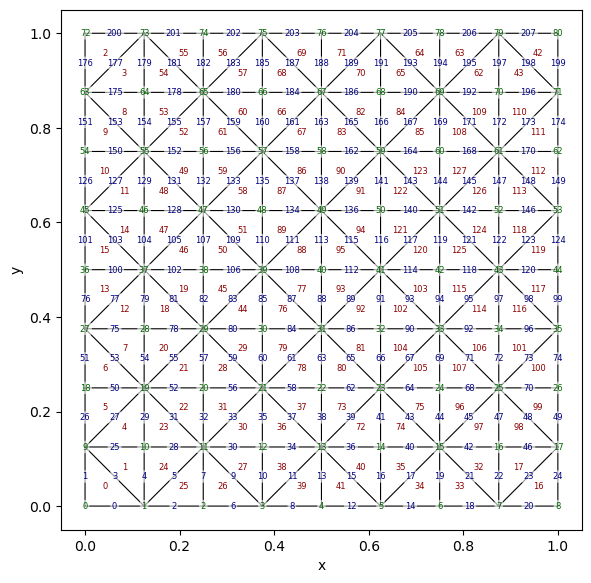

In [3]:
mesh.plot_topology(
    element_color = "darkred",
    face_color = "navy",
    node_color = "darkgreen",
    element_size = 6,
    face_size = 6,
    node_size = 6,
    figsize = (6, 6)
)
# 9 

## Definición del problema FVM

In [4]:
p = FVMProblem(mesh)
p.initialize_phi(0.)
p._update_gradients()

## Coeficiente de difusión

In [5]:
def my_gamma(p):
    return np.full(p.Ne, 1.0)

p.gamma_function = my_gamma

p.initialize_gamma()
p.compute_diffusion_coefficients()

## Condiciones de borde

In [6]:
tol = 1e-6
face_centers = np.array([f.center for f in p.mesh.faces])

left_bound = np.where(np.abs(face_centers[:, 0]) < tol)[0]
right_bound = np.where(np.abs(face_centers[:, 0] - xl) < tol)[0]
down_bound = np.where(np.abs(face_centers[:, 1]) < tol)[0]
up_bound = np.where(np.abs(face_centers[:, 1] - yl) < tol)[0]

bounds = {
    "left_bound"  : left_bound,
    "right_bound" : right_bound,
    "down_bound"  : down_bound,
    "up_bound"    : up_bound
}

p.create_boundary_patches(bounds)

In [7]:
def my_boundary_sources(p):
    Sc = np.zeros(p.Ne)
    Sp = np.zeros(p.Ne)

    patch = p.left_bound
    gamma = p.Gamma_f[patch.faces]
    coeff = gamma * patch.Sf_norm / patch.dCf_norm
    Sp[patch.cells] += coeff
    Sc[patch.cells] += coeff * 0

    patch = p.right_bound
    gamma = p.Gamma_f[patch.faces]
    coeff = gamma * patch.Sf_norm / patch.dCf_norm
    Sp[patch.cells] += coeff
    Sc[patch.cells] += coeff * 0

    patch = p.down_bound
    gamma = p.Gamma_f[patch.faces]
    coeff = gamma * patch.Sf_norm / patch.dCf_norm
    Sp[patch.cells] += coeff
    Sc[patch.cells] += coeff * 0

    patch = p.up_bound
    gamma = p.Gamma_f[patch.faces]
    coeff = gamma * patch.Sf_norm / patch.dCf_norm
    Sp[patch.cells] += coeff
    Sc[patch.cells] += coeff * 0
    return Sc, Sp

p.boundary_sources_function = my_boundary_sources
p.calculate_boundary_sources()

[  1  26  51  76 101 126 151 176]
[ 24  49  74  99 124 149 174 199]
[ 0  2  6  8 12 14 18 20]
[200 201 202 203 204 205 206 207]


## Fuente volumétrica

**Evaluación en centroides**

```python
centroids = np.array([c.centroid for c in p.mesh.elements])
volumes = np.array([c.volume for c in p.mesh.elements])
```

Se extraen:

* Coordenadas de centros de celda.
* Volúmenes de control.

---

**Definición del término fuente**

```python
source = 2 * np.pi**2 * np.sin(np.pi * x) * np.sin(np.pi * y)
```

Esto corresponde exactamente a:

$$
S(x,y) = 2\pi^2 \sin(\pi x)\sin(\pi y)
$$

---

**Integración sobre volumen**

En FVM el término fuente se integra sobre el volumen de control:

$$
\int_V S , dV \approx S(x_C,y_C) V_C
$$

Por eso:

```python
Sc[:] += source * volumes
```

No hay término lineal:

```python
Sp[:] += 0
```

In [9]:
def my_volumetric_sources(p):

    Sc = np.zeros(p.Ne)
    Sp = np.zeros(p.Ne)
    
    centroids = np.array([c.centroid for c in p.mesh.elements])
    volumes = np.array([c.volume for c in p.mesh.elements])
    
    x = centroids[:,0]
    y = centroids[:,1]
    
    source = 2 * np.pi**2 * np.sin(np.pi * x) * np.sin(np.pi * y)
    
    Sc[:] += source * volumes
    Sp[:] += 0

    return Sc, Sp

In [10]:
p.volumetric_sources_function = my_volumetric_sources
p.calculate_volumetric_sources()

## Resolución

In [11]:
p.assemble_system()
p.solve()

problem solved...


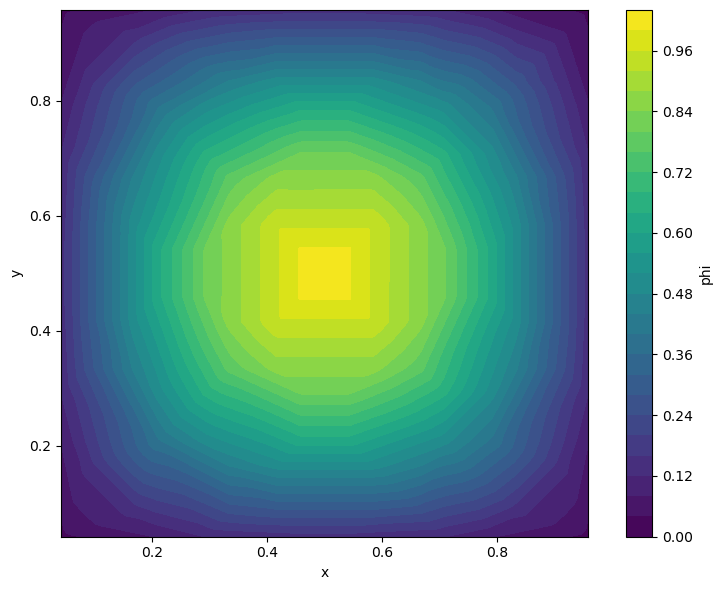

In [12]:
plot_phi_contours(
    p,
    field="cell",
    levels = 30,
    include_internal_faces=False,
    include_boundary_faces=True,
    show_contour_lines=False,
)

## Validación

In [25]:

def run_case(nx):

    xl = yl = 1.0

    x = np.linspace(0.0, xl, nx)
    y = np.linspace(0.0, yl, nx)
    X, Y = np.meshgrid(x, y)
    points = np.column_stack((X.ravel(), Y.ravel()))

    tess = Tessellation(points)
    mesh = MeshFVM(tess)
    mesh.compute_fvm_geometry()

    p = FVMProblem(mesh)
    p.initialize_phi(0.)

    # Gamma constante
    def my_gamma(p):
        return np.ones(p.Ne)

    p.gamma_function = my_gamma
    p.initialize_gamma()
    p.compute_diffusion_coefficients()

    # ----------------------------
    # Boundary patches
    # ----------------------------
    tol = 1e-6
    face_centers = np.array([f.center for f in p.mesh.faces])

    left  = np.where(np.abs(face_centers[:,0]) < tol)[0]
    right = np.where(np.abs(face_centers[:,0] - xl) < tol)[0]
    down  = np.where(np.abs(face_centers[:,1]) < tol)[0]
    up    = np.where(np.abs(face_centers[:,1] - yl) < tol)[0]

    bounds = {
        "left_bound"  : left,
        "right_bound" : right,
        "down_bound"  : down,
        "up_bound"    : up
    }

    p.create_boundary_patches(bounds)

    # ----------------------------
    # Boundary sources
    # ----------------------------
    def my_boundary_sources(p):

        Sc = np.zeros(p.Ne)
        Sp = np.zeros(p.Ne)

        for patch in [p.left_bound, p.right_bound,
                      p.down_bound, p.up_bound]:

            gamma = p.Gamma_f[patch.faces]
            coeff = gamma * patch.Sf_norm / patch.dCf_norm

            Sp[patch.cells] += coeff
            Sc[patch.cells] += 0.0

        return Sc, Sp

    p.boundary_sources_function = my_boundary_sources
    p.calculate_boundary_sources()

    # ----------------------------
    # Volumetric source
    # ----------------------------
    def my_volumetric_sources(p):

        Sc = np.zeros(p.Ne)
        Sp = np.zeros(p.Ne)

        centroids = np.array([c.centroid for c in p.mesh.elements])
        volumes   = np.array([c.volume for c in p.mesh.elements])

        x = centroids[:,0]
        y = centroids[:,1]

        source = 2 * np.pi**2 * np.sin(np.pi*x)*np.sin(np.pi*y)

        Sc += source * volumes

        return Sc, Sp

    p.volumetric_sources_function = my_volumetric_sources
    p.calculate_volumetric_sources()

    # ----------------------------
    # Solve
    # ----------------------------
    p.assemble_system()
    p.solve()
    #p.solve_nonlinear()

    # ----------------------------
    # Error
    # ----------------------------
    centroids = np.array([c.centroid for c in p.mesh.elements])
    x = centroids[:,0]
    y = centroids[:,1]

    phi_exact = np.sin(np.pi*x)*np.sin(np.pi*y)

    error = p.phi_C - phi_exact

    L2 = np.sqrt(np.mean(error**2))

    return L2


In [26]:
resolutions = [8, 12, 16, 24, 32, 48, 64, 120, 150, 210]
errors = []

for n in resolutions:
    print(f"Running {n}x{n}...")
    L2 = run_case(n)
    errors.append(L2)

errors = np.array(errors)


Running 8x8...
problem solved...
Running 12x12...
problem solved...
Running 16x16...
problem solved...
Running 24x24...
problem solved...
Running 32x32...
problem solved...
Running 48x48...
problem solved...
Running 64x64...
problem solved...
Running 120x120...
problem solved...
Running 150x150...
problem solved...
Running 210x210...
problem solved...


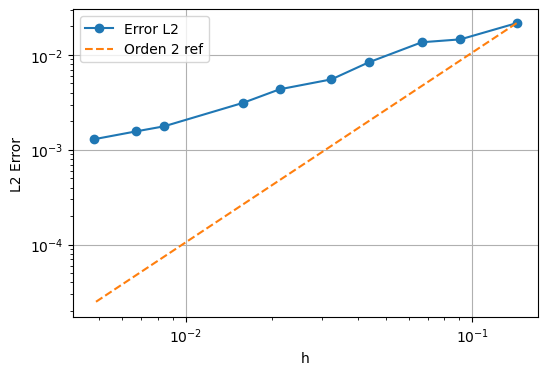

Orden estimado = 0.8689755004346901


In [27]:
h = 1 / (np.array(resolutions) - 1)

plt.figure(figsize = (6, 4))
plt.loglog(h, errors, 'o-', label='Error L2')
plt.loglog(h, h**2 * errors[0]/h[0]**2, '--', label='Orden 2 ref')
plt.xlabel("h")
plt.ylabel("L2 Error")
plt.legend()
plt.grid(True)
plt.show()

# Estimación del orden
p_fit = np.polyfit(np.log(h), np.log(errors), 1)
print("Orden estimado =", p_fit[0])


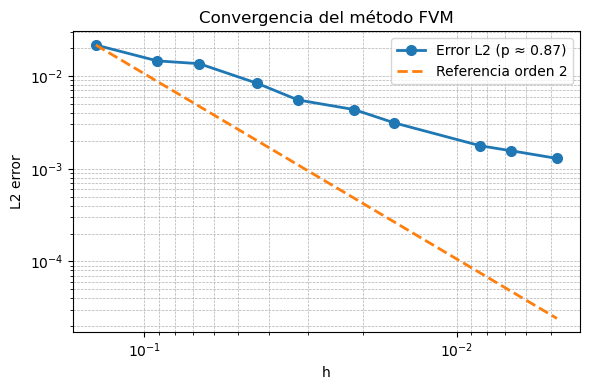

Orden estimado = 0.8689755004346901


In [28]:
# -----------------------------------
# Datos
# -----------------------------------
resolutions = np.array(resolutions)
errors = np.array(errors)

h = 1.0 / (resolutions - 1)

# Orden estimado
p_fit = np.polyfit(np.log(h), np.log(errors), 1)
order_estimated = p_fit[0]

# Línea de referencia orden 2
ref_order = 2.0
C_ref = errors[0] / (h[0]**ref_order)
ref_line = C_ref * h**ref_order

# -----------------------------------
# Gráfico
# -----------------------------------
plt.figure(figsize=(6, 4))

plt.loglog(h, errors, 'o-', linewidth=2, markersize=7,
           label=f'Error L2 (p ≈ {order_estimated:.2f})')

plt.loglog(h, ref_line, '--', linewidth=2,
           label='Referencia orden 2')

plt.gca().invert_xaxis()  # h decrece hacia la derecha

plt.xlabel('h')
plt.ylabel('L2 error')
plt.title('Convergencia del método FVM')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

plt.tight_layout()
plt.show()

print("Orden estimado =", order_estimated)